# Import libraries

In [44]:
import numpy as np
import pandas as pd
import os
import torch
import re
import string
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from collections import defaultdict, Counter
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline
from itertools import chain
import spacy
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

In [28]:
NEGATION_CUES = {
    "syntactic::sentential_particle": {r"\bnot\b"},
    "syntactic::neg_contraction": {r"n't\b"},
    "syntactic::negative_adverb": {r"\bnever\b", r"\bhardly\b", r"\bseldom\b"},
    "lexical_semantic::negative_determiner": {r"\bno\b"},
    "lexical_semantic::negative_pronoun": {r"\bnothing\b", r"\bnobody\b", r"\bnone\b", r"\bnowhere\b"},
    "lexical_semantic::negative_preposition": {r"\bwithout\b", r"\bsans\b", r"\bminus\b"},
    "lexical_semantic::negative_verb": {r"\black\b", r"\blacking\b", r"\blacked\b", r"\blacks\b"},
    "lexical_semantic::negative_adjective": {r"\babsent\b", r"\bmissing\b", r"\bunavailable\b"},
    "pragmatic::litotes": {r"\bnot\s+\w+\b"}
}
COMPILED = {
    label: [re.compile(pat, flags=re.I) for pat in patterns]
    for label, patterns in NEGATION_CUES.items()
}
TOKEN_REGEX = re.compile(r"\b\w+'\w+|\w+\b")
NEG_PREFIXES = ["un", "in", "im", "il", "ir", "dis", "non", "mis"]
NEG_SUFFIXES = ["less", "free"]

def detect_negation(text: str):
    labels = set()
    cues = defaultdict(set)
    # 1. Phrase-level
    for label, regs in COMPILED.items():
        for rgx in regs:
            for m in rgx.finditer(text):
                labels.add(label)
                cues[label].add(m.group(0).lower())
    # 2. Morphological
    tokens = TOKEN_REGEX.findall(text)
    for tok in tokens:
        low = tok.lower()
        # prefix check
        for pre in NEG_PREFIXES:
            if low.startswith(pre) and len(low) > len(pre) + 1:
                labels.add("morphological::neg_prefix")
                cues["morphological::neg_prefix"].add(low)
                break
        # suffix check
        for suf in NEG_SUFFIXES:
            if low.endswith(suf) and len(low) > len(suf) + 1:
                labels.add("morphological::neg_suffix")
                cues["morphological::neg_suffix"].add(low)
                break
    return sorted(labels), {k: sorted(v) for k, v in cues.items()}


# Load COCO captions generated using Llama 3.1

## COCO retrieval

In [71]:
path = '/Users/akanshagautam/Documents/MTech/Thesis/Dataset/NegClip/NegBench/evaluation data/images/COCO_val_negated_retrieval_llama3.1_rephrased_affneg_true.csv'

coco_retrieval = pd.read_csv(path)
print(coco_retrieval.shape)
coco_retrieval.head(3)

(5000, 5)


,positive_objects,negative_objects,filepath,image_id,captions
0,"['person', 'bottle', 'cup', 'knife', 'spoon', 'bowl', 'broccoli', 'carrot', 'dining table', 'oven', 'sink']","['chair', 'fork', 'car']",data/coco/images/val2017/000000397133.jpg,397133,"['A man in a kitchen is making pizzas, but there is no chair in sight.', 'A man in an apron stands in front of an oven with pans and bakeware nearby, without a chair in sight.', 'No fork is present, but a baker is busy working in the kitchen, rolling out dough.', 'A person stands by a stove in the kitchen, but a fork is noticeably absent.', ""At the table, pies are being crafted, while a person stands by a wall adorned with pots and pans, and noticeably, there's no fork.""]"
1,"['banana', 'orange', 'chair', 'potted plant', 'dining table', 'oven', 'sink', 'refrigerator']","['person', 'cup', 'bottle']",data/coco/images/val2017/000000037777.jpg,37777,"['No cup can be seen; however, the dining table near the kitchen is set with a bowl of fruit.', 'No cup is visible in the image, but the small kitchen is equipped with various appliances and a table.', 'The kitchen is clean and empty, with no person in sight.', 'In this pristine white kitchen and dining area, no bottle is in sight.', 'A kitchen scene featuring a bowl of fruit on the table, but noticeably absent is a bottle.']"
2,"['person', 'traffic light', 'umbrella', 'handbag', 'cup']","['chair', 'car', 'dining table']",data/coco/images/val2017/000000252219.jpg,252219,"['A person with a shopping cart is on a city street, with no car in sight.', 'No dining table is visible in the image, which shows city dwellers passing by a homeless man begging for cash.', 'On a city street, people walk past a homeless man begging, with no chair in sight.', 'On the street, a homeless man holds a cup and stands beside a shopping cart, with no sign of a car.', 'People walk by a homeless person standing on the street, with no cars in the surrounding area.']"


In [72]:
# ─────────────────────────────────────────────────────────────
# Apply to every caption
#     Explode the list column so each row = 1 caption
# ─────────────────────────────────────────────────────────────
df_exp = coco_retrieval.explode("captions", ignore_index=True)
df_exp[["negation_types", "negation_cues"]] = df_exp["captions"].apply(
    lambda txt: pd.Series(detect_negation(txt))
)

# ─────────────────────────────────────────────────────────────
# Aggregate stats
# ─────────────────────────────────────────────────────────────
freq = Counter(chain.from_iterable(df_exp["negation_types"]))

# ─────────────────────────────────────────────────────────────
# View / save results
# ─────────────────────────────────────────────────────────────
print("\n─ Annotated sample ─")
df_exp[["image_id", "captions", "negation_types", "negation_cues"]].head(3)


─ Annotated sample ─


,image_id,captions,negation_types,negation_cues
0,397133,"['A man in a kitchen is making pizzas, but there is no chair in sight.', 'A man in an apron stands in front of an oven with pans and bakeware nearby, without a chair in sight.', 'No fork is present, but a baker is busy working in the kitchen, rolling out dough.', 'A person stands by a stove in the kitchen, but a fork is noticeably absent.', ""At the table, pies are being crafted, while a person stands by a wall adorned with pots and pans, and noticeably, there's no fork.""]","[lexical_semantic::negative_adjective, lexical_semantic::negative_determiner, lexical_semantic::negative_preposition]","{'lexical_semantic::negative_determiner': ['no'], 'lexical_semantic::negative_preposition': ['without'], 'lexical_semantic::negative_adjective': ['absent']}"
1,37777,"['No cup can be seen; however, the dining table near the kitchen is set with a bowl of fruit.', 'No cup is visible in the image, but the small kitchen is equipped with various appliances and a table.', 'The kitchen is clean and empty, with no person in sight.', 'In this pristine white kitchen and dining area, no bottle is in sight.', 'A kitchen scene featuring a bowl of fruit on the table, but noticeably absent is a bottle.']","[lexical_semantic::negative_adjective, lexical_semantic::negative_determiner, morphological::neg_prefix]","{'lexical_semantic::negative_determiner': ['no'], 'lexical_semantic::negative_adjective': ['absent'], 'morphological::neg_prefix': ['image']}"
2,252219,"['A person with a shopping cart is on a city street, with no car in sight.', 'No dining table is visible in the image, which shows city dwellers passing by a homeless man begging for cash.', 'On a city street, people walk past a homeless man begging, with no chair in sight.', 'On the street, a homeless man holds a cup and stands beside a shopping cart, with no sign of a car.', 'People walk by a homeless person standing on the street, with no cars in the surrounding area.']","[lexical_semantic::negative_determiner, morphological::neg_prefix, morphological::neg_suffix]","{'lexical_semantic::negative_determiner': ['no'], 'morphological::neg_prefix': ['image'], 'morphological::neg_suffix': ['homeless']}"


In [73]:
for subtype, cnt in freq.most_common():
    print(f"{subtype:38} {cnt}")

lexical_semantic::negative_determiner  4997
morphological::neg_prefix              4773
lexical_semantic::negative_preposition 776
lexical_semantic::negative_adjective   567
syntactic::sentential_particle         225
pragmatic::litotes                     224
lexical_semantic::negative_pronoun     167
lexical_semantic::negative_verb        99
morphological::neg_suffix              55
syntactic::neg_contraction             29
syntactic::negative_adverb             1


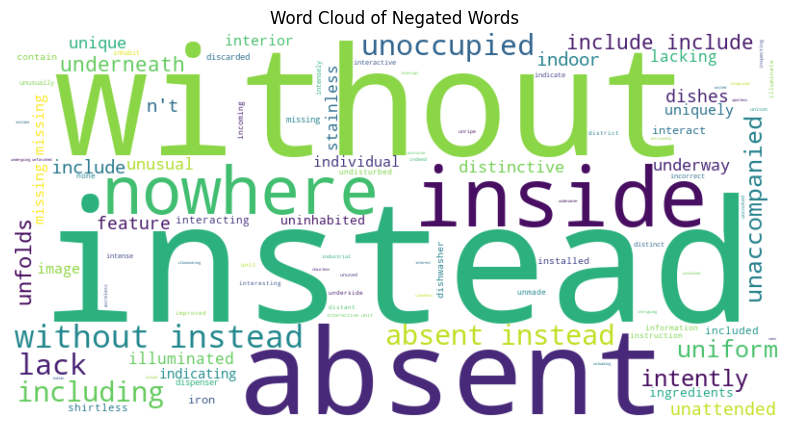

In [74]:
negated_words = list(chain.from_iterable(
    chain.from_iterable(cues.values() for cues in df_exp['negation_cues'])
))

undesired_words = {"image", "intersection", "displays", "distance", "display", "displayed", "displaying"}
cleaned_negated_words = [word for word in negated_words if word not in undesired_words]

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(cleaned_negated_words))

# Plot
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud of Negated Words")
plt.show()

In [59]:
# nlp = spacy.load("en_core_web_sm")
# df_exp = coco_retrieval.explode("captions", ignore_index=True)

# def detect_negation_spacy(text):
#     doc = nlp(text)
#     neg_cues = []

#     # Iterate over sentences
#     for sentence in doc.sents:
#         for token in sentence:
#             if token.dep_ == "neg":
#                 # Get the negated word (head of the negation)
#                 negated_word = token.head.text
#                 # Combine cue + head for clarity
#                 neg_phrase = f"{token.text} {negated_word}"
#                 neg_cues.append(neg_phrase)
#     return neg_cues

# # # Annotate captions
# df_exp["negation_cues"] = df_exp["captions"].apply(detect_negation_spacy)

# # # Display annotated dataframe
# df_exp[["image_id", "captions", "negation_cues"]].head(3)

In [58]:
# text = "A man in a kitchen is making pizzas, but there is no chair in sight"
# doc = nlp(text)
# for token in doc:
#     print(token, " ", token.dep_)
#     if token.dep_ == "neg":
#         print("------------found")

A   det
man   nsubj
in   prep
a   det
kitchen   pobj
is   aux
making   ROOT
pizzas   dobj
,   punct
but   cc
there   expl
is   conj
no   det
chair   attr
in   prep
sight   pobj


## COCO MCQ

In [75]:
path = '/Users/akanshagautam/Documents/MTech/Thesis/Dataset/NegClip/NegBench/evaluation data/images/COCO_val_mcq_llama3.1_rephrased.csv'

coco_mcq = pd.read_csv(path)

coco_mcq.head(3)

,image_path,correct_answer,caption_0,caption_1,caption_2,caption_3,correct_answer_template
0,data/coco/images/val2017/000000397133.jpg,0,"This image features a knife, but no car is present.","A car is present in this image, but there is no knife.",This image features a car,This image does not feature a knife.,hybrid
1,data/coco/images/val2017/000000397133.jpg,0,A chair is not present in this image.,"This image shows a chair, but no spoon is present.",A chair is present in this image.,A spoon is not included in this image.,negative
2,data/coco/images/val2017/000000397133.jpg,0,"A person is present in this image, but there's no fork.","This image shows a fork, with no person in sight.",A fork is shown in this image.,No person is present in this image.,hybrid


In [81]:
df_melted = coco_mcq.melt(
    id_vars=["image_path"], 
    value_vars=["caption_0", "caption_1", "caption_2", "caption_3"], 
    var_name="caption_index", 
    value_name="caption"
)

df_melted[["negation_types", "negation_cues"]] = df_melted["caption"].apply(
    lambda txt: pd.Series(detect_negation(txt))
)

df_wide = df_melted.pivot_table(
    index="image_path",
    columns="caption_index",
    values=["caption", "negation_types", "negation_cues"],
    aggfunc="first"
)
df_wide.columns = ["_".join(col).strip() for col in df_wide.columns.values]
df_wide = df_wide.reset_index()

print("\n─ Annotated sample ─")
df_wide.head(3)


─ Annotated sample ─


,image_path,caption_caption_0,caption_caption_1,caption_caption_2,caption_caption_3,negation_cues_caption_0,negation_cues_caption_1,negation_cues_caption_2,negation_cues_caption_3,negation_types_caption_0,negation_types_caption_1,negation_types_caption_2,negation_types_caption_3
0,data/coco/images/val2017/000000000139.jpg,There is no cup in this image.,"This image features a cup, but no book is visible.",A cup is shown in this image.,No book is present in this image,"{'lexical_semantic::negative_determiner': ['no'], 'morphological::neg_prefix': ['image']}","{'lexical_semantic::negative_determiner': ['no'], 'morphological::neg_prefix': ['image']}",{'morphological::neg_prefix': ['image']},"{'lexical_semantic::negative_determiner': ['no'], 'morphological::neg_prefix': ['image']}","[lexical_semantic::negative_determiner, morphological::neg_prefix]","[lexical_semantic::negative_determiner, morphological::neg_prefix]",[morphological::neg_prefix],"[lexical_semantic::negative_determiner, morphological::neg_prefix]"
1,data/coco/images/val2017/000000000632.jpg,A bed and chair are present in this image.,"This image features a person, with no bed in sight.",A person is in this image.,A bed is not present in this image.,{'morphological::neg_prefix': ['image']},"{'lexical_semantic::negative_determiner': ['no'], 'morphological::neg_prefix': ['image']}",{'morphological::neg_prefix': ['image']},"{'syntactic::sentential_particle': ['not'], 'pragmatic::litotes': ['not present'], 'morphological::neg_prefix': ['image']}",[morphological::neg_prefix],"[lexical_semantic::negative_determiner, morphological::neg_prefix]",[morphological::neg_prefix],"[morphological::neg_prefix, pragmatic::litotes, syntactic::sentential_particle]"
2,data/coco/images/val2017/000000000724.jpg,This image features a car and a stop sign.,"This image features a person, with no car in sight.",This image features a person.,This image does not have a car,{'morphological::neg_prefix': ['image']},"{'lexical_semantic::negative_determiner': ['no'], 'morphological::neg_prefix': ['image']}",{'morphological::neg_prefix': ['image']},"{'syntactic::sentential_particle': ['not'], 'pragmatic::litotes': ['not have'], 'morphological::neg_prefix': ['image']}",[morphological::neg_prefix],"[lexical_semantic::negative_determiner, morphological::neg_prefix]",[morphological::neg_prefix],"[morphological::neg_prefix, pragmatic::litotes, syntactic::sentential_particle]"


In [102]:
negation_cue_columns = ["negation_cues_caption_0", "negation_cues_caption_1", "negation_cues_caption_2", "negation_cues_caption_3"]

negated_words = [
    word
    for col in negation_cue_columns
    for cues in df_wide[col].dropna()
    for word_list in cues.values()
    for word in word_list
]

undesired_words = {"image", "intersection", "displays", "distance", "display", "displayed", "displaying", "included", "include", "includes"}
cleaned_negated_words = [word for word in negated_words if word not in undesired_words]

negated_word_freq = dict(sorted(Counter(cleaned_negated_words).items(), key=lambda item: item[1], reverse=True))

negated_word_freq

{'no': 7569,
 'not': 2214,
 'not present': 852,
 'not included': 446,
 'absent': 253,
 'not include': 248,
 'lacks': 231,
 'not feature': 212,
 'not have': 93,
 'not in': 81,
 'without': 72,
 'not shown': 63,
 'not contain': 59,
 "n't": 37,
 'nowhere': 37,
 'not visible': 35,
 'not a': 24,
 'not show': 11,
 'missing': 6,
 'not featured': 5,
 'incorrect': 4,
 'unoccupied': 4,
 'not chair': 3,
 'introduces': 3,
 'information': 1,
 'not valid': 1,
 'not need': 1,
 'not seen': 1,
 'not suitcase': 1,
 'not skis': 1,
 'nothing': 1,
 'not found': 1,
 'invalid': 1,
 'not find': 1,
 'not depict': 1,
 'imageentialaction': 1}